<a href="https://colab.research.google.com/github/lasupernova/Tensorflow_apps/blob/master/Food_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
#ensure GPU compute capability is > 7.0 in order to use mixed precision training acceleration
# here: Tesla T4 needed
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c12b842b-5465-8af9-05f0-9dc83739e13f)


In [55]:
#download helper functions script from Github
!wget https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py

--2021-09-30 21:18:37--  https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10252 (10K) [text/plain]
Saving to: ‘helpers.py.2’

helpers.py.2        100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-30 21:18:37 (65.7 MB/s) - ‘helpers.py.2’ saved [10252/10252]



In [56]:
import tensorflow as tf

In [57]:
#import helper functions from script
from helpers import create_tensorboard_callback, plot_loss_curves#, compare_histories

##Load Data

In [58]:
#import tf Datasets to download Food 101 dataset using later on 
import tensorflow_datasets as tfds

In [59]:
#overview of all available datasets
datasets_list = tfds.list_builders()

In [60]:
datasets_list;

In [61]:
#load food101 data from tf Datasets
(train_data, test_data), food_info = tfds.load(name="food101",
                                               split=["train", "validation"],
                                               shuffle_files=True,
                                               as_supervised=True,
                                               with_info=True)

##Explore Data

In [62]:
#get to know dataset
food_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [63]:
#get class names
class_names = food_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [64]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [65]:
import matplotlib.pyplot as plt
def explore_data(num_images=9):
  for i in range(num_images):
    train_sample_explore = train_data.take(1)
    # train_sample_explore
    #each sample comes with data (here: image) and a label
    for img, label in train_sample_explore:
      # print(label)  #label is a tensor containing the image class number --> convert to number/np-array (using numpy) in order to translate to class_name
      shape = img.shape
      datatype= img.dtype.name
      img_label = class_names[label.numpy()]
      #Get min and max values in image tensor
      min_val = tf.reduce_min(img); max_val=tf.reduce_max(img)
      normalized = (min_val.numpy()==0 and max_val.numpy()==1)
      normalized_str = "True (min:0, max:1)" if normalized else f'False (value range: {min_val.numpy()} - {max_val.numpy()})'
      info_str = f"""Image has the following features:
          Shape:       {shape}
          dtype:       {datatype}
          Class Name:  {img_label}
          Dataset target class tensor form: {label}
          Normalized:  {normalized_str}"""
    #Plot selected image
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(img_label)
    plt.text(x=shape[1]*1.05,y=shape[0]/2,s=info_str)
    ax=plt.gca()
    ax.set_axis_off()  #or use plt.axis(False)
    plt.show()

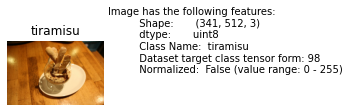

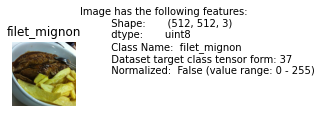

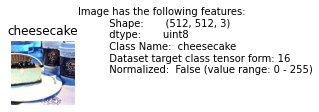

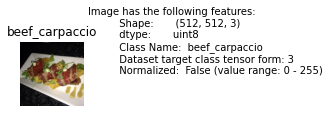

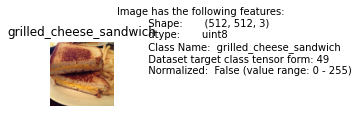

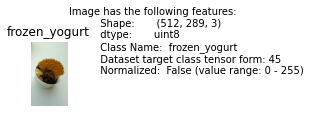

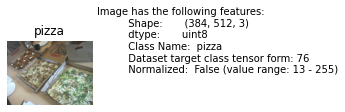

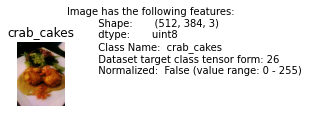

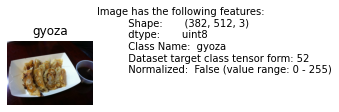

In [66]:
explore_data()

NOTE: image tensor is not yet normalized (as min - max values are not 0 and 1)

NOTE: dataset labels are *NOT* one-hot encoded as the target class tensor contains **one** individual number as opposed to aan array/ a list of the form [0,0,0,1....,0,0]. <br><br>
Additionally, running the cell above for multiple images has shown, that images are *not* of same shape (for height and width).

##Pre-process Images

In [67]:
#pre-processing function (instead of using tf.keras.preprocessing.image_dataset_from_directory)
def preprocess_image(img, label, img_size=224, scale=False):
  """
  Takes image and preprocesses it to standard image, inluding:
    datatype (float32),
    shape([img_size, img_size, color_channel])
    normalization (shouldvalues be scaled to values between 0 - 1)

  Params:
    img - tensor containing image to be preprocessed
    label - number representing class of image
    img_size - number to use for image width and height
    scale - bool to determine if tensor should be normalized (default : True)

  Returns:
    mod_img - modified, preprocessed image
  """
  mod_img = tf.image.resize(img, [img_size, img_size]) #resize height + width
  if scale:
    mod_img = mod_img/255. #normalize
  return tf.cast(mod_img, tf.float32), label  #return float32 -version of modified tensor (could have been, e.g.  uint8 before, but NNs need float32)

In [68]:
test_img = train_data.take(1)

In [69]:
test_img

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [70]:
for img, label in test_img:
  mod, t_label = preprocess_image(img, class_names[label.numpy()], 224, scale=False)

In [71]:
mod, t_label

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         ...,
         [105.41832   ,  62.20402   ,  30.846907  ],
         [ 96.02032   ,  53.811165  ,  24.214216  ],
         [ 89.12756   ,  48.127567  ,  18.127565  ]],
 
        [[  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         ...,
         [104.484634  ,  63.48463   ,  31.913221  ],
         [ 91.632515  ,  52.35704   ,  21.494778  ],
         [ 78.1633    ,  40.903084  ,   9.331657  ]],
 
        [[  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         ...,
         [ 98.23974   ,  62.28566   ,  29.142822  ],
         [ 88.31623   ,  53.65809   ,  21.887678

## Batch and Prepare Datasets

In [72]:
#map custom preprocessing function to train dataset
"""NOTE: each entry in the dataset consists of 2 parts (a tensor and a label) 
--> the undefined params from the passed function, must also be 2, so that this function will know which input to map to which params
--> more params can be used in fucntion, however these need to have default values (which will then be used during the mapping call)
"""
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

#map custom preprocessing function to test dataset
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [73]:
#shuffle training data and group into batches
train_data = train_data.shuffle(buffer_size=5000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#shuffle testinging data and group into batches
test_data = test_data.shuffle(buffer_size=5000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [74]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

NOTE: an additional dimension (for batching) is now added in the dataset

## Modelling callbacks creation

In [75]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helpers import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", 
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=0) 

In [76]:
# #set up mixed precision training --> will only work with Tesla T4 GPU -- comment out otherwise
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

## Build Model

In [77]:
#feature extraction model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#add changes (functional model)
inputs = layers.Input(shape=input_shape, name="input")
# x = preprocessing.Rescaling(1./255)(x)  #uncomment if chosen model does not have built-in rescaling
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="globavgpool")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", name="softmax_output")(x)  #if mixed precision is enables and used, use instead: layers.Activation("softmax", name="softmax_output", dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)

In [78]:
#compile model
model.compile(
    loss="sparse_categorical_crossentropy",  #use "sparse_categorical_crossentropy" instead of "categorical_crossentropy" when using int classes instead of one-hot-encoded classes
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [79]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
globavgpool (GlobalAveragePo (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_output (Activation)  (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [80]:
for layer in model.layers:
  print(f"Name: {layer.name:>15}, Trainable: {layer.trainable:>1}, dtype: {layer.dtype}, dtype policy: {layer.dtype_policy}")

Name:           input, Trainable: 1, dtype: float32, dtype policy: <Policy "float32">
Name:  efficientnetb0, Trainable: 0, dtype: float32, dtype policy: <Policy "float32">
Name:     globavgpool, Trainable: 1, dtype: float32, dtype policy: <Policy "float32">
Name:         dense_1, Trainable: 1, dtype: float32, dtype policy: <Policy "float32">
Name:  softmax_output, Trainable: 1, dtype: float32, dtype policy: <Policy "float32">


In [81]:
# #check dtype specs of all layers within the base model (is integrated at index 1 of current model)
# for layer in model.layers[1].layers:
#   print(f"Name: {layer.name:>20}, Trainable: {layer.trainable:>1}, dtype: {layer.dtype}, dtype policy: {layer.dtype_policy}")

In [82]:
#fit model
history_101_big_food_vision = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101")]
)

Saving TensorBoard log files to: training_logs/efficientnetb0_101/20210930-211844
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2368/2368 [==============================] - 348s 140ms/step - loss: 1.8197 - accuracy: 0.5573 - val_loss: 1.2290 - val_accuracy: 0.6766
Epoch 2/3
2368/2368 [==============================] - 341s 140ms/step - loss: 1.2935 - accuracy: 0.6657 - val_loss: 1.1212 - val_accuracy: 0.7002
Epoch 3/3
2368/2368 [==============================] - 339s 139ms/step - loss: 1.1431 - accuracy: 0.7021 - val_loss: 1.0808 - val_accuracy: 0.7042


In [83]:
model.evaluate(test_data)

790/790 [==============================] - 110s 128ms/step - loss: 1.0947 - accuracy: 0.7039


[1.0946999788284302, 0.7039207816123962]

In [84]:
# Clone the model we created --> resets all weights
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
globavgpool (GlobalAveragePo (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_output (Activation)  (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [85]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

NotFoundError: ignored

In [51]:
!ls saved_models/

checkpoint  feat_extr.data-00000-of-00001  feat_extr.index
